### Necessary Packages

In [1]:
import torch
import sys
import dotenv
import os
import torch
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('../..')
from src.models import AttentionModel
from torch.utils.data import DataLoader
from torchvision.transforms import Lambda
from src.utils import load_model_from_folder,load_history_from_folder
from src.datasets import TensorDataset
from tqdm.notebook import tqdm
from torchmetrics import F1Score,Accuracy,AUROC,Metric

Key OPENSLIDE_PATH not found in /home/abdelnour/Documents/4eme_anne/S2/projet/.env.


### Setup the code to be device agnostic

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device.type)

cuda


### Results reproducibility

In [3]:
torch.manual_seed(0)

### Loading envirement variables

In [4]:
GFE_FOLDER = dotenv.get_key(dotenv.find_dotenv(), "GFE_FOLDER")
MODELS_DIR = dotenv.get_key(dotenv.find_dotenv(), "MODELS_DIR")
HISTORIES_DIR = dotenv.get_key(dotenv.find_dotenv(), "HISTORIES_DIR")

In [5]:
TRAIN_DIR = os.path.join(GFE_FOLDER, "train")
VAL_DIR = os.path.join(GFE_FOLDER, "val")
TEST_DIR = os.path.join(GFE_FOLDER, "test")

In [6]:
print(MODELS_DIR)
print(GFE_FOLDER)
print(HISTORIES_DIR)
print(TRAIN_DIR)
print(VAL_DIR)
print(TEST_DIR)

/home/abdelnour/Documents/4eme_anne/S2/projet/models
/home/abdelnour/Documents/4eme_anne/S2/projet/data/ResNet34_tensors
/home/abdelnour/Documents/4eme_anne/S2/projet/histories
/home/abdelnour/Documents/4eme_anne/S2/projet/data/ResNet34_tensors/train
/home/abdelnour/Documents/4eme_anne/S2/projet/data/ResNet34_tensors/val
/home/abdelnour/Documents/4eme_anne/S2/projet/data/ResNet34_tensors/test


### Global

In [7]:
BATCH_SIZE = 1
NUM_WORKERS = 0
PREFETCH_FACTOR = None
WEIGHTS_FOLDER  = os.path.join(MODELS_DIR, "attention_resnet34")
HISTORIES_FOLDER = path = os.path.join(HISTORIES_DIR, "attention_resnet34")

### Load the model

In [8]:
model = AttentionModel(
    num_classes=3,
    dropout=0.2,
    filters_in=512,
    filters_out=64
).to(device)

In [10]:
load_model_from_folder(model, WEIGHTS_FOLDER, verbose=True)

loading weights with name : 1714186317.7408254.pt


### Learning graph

In [11]:
history_df = load_history_from_folder(HISTORIES_FOLDER)

<Axes: xlabel='epoch', ylabel='accuracy'>

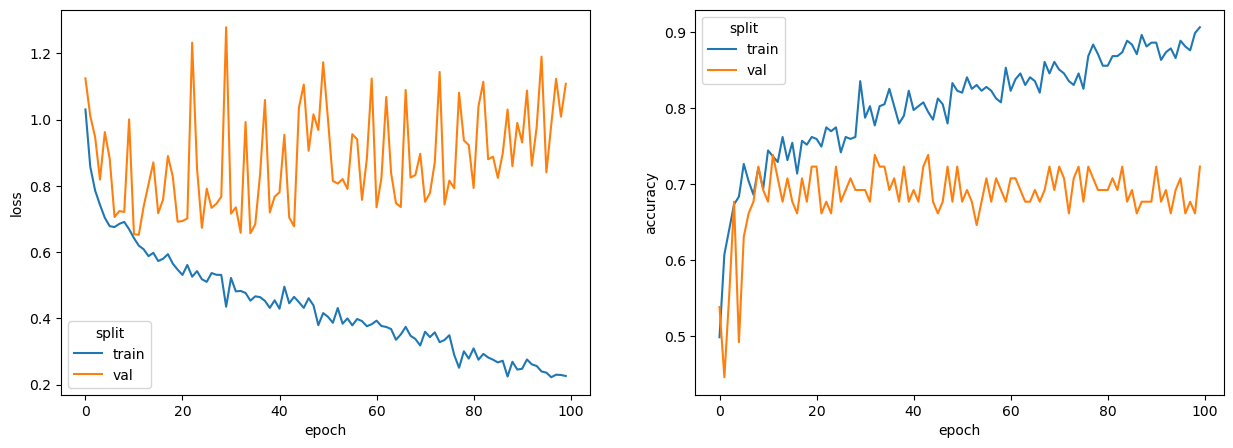

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

fig.set_size_inches(15, 5)

sns.lineplot(data=history_df, x="epoch", y="loss", hue="split", ax=ax1)
sns.lineplot(data=history_df, x="epoch", y="accuracy", hue="split", ax=ax2)

### Data Loading

In [12]:
transfrom = Lambda(lambd=lambda x : torch.unsqueeze(x, dim=0))
datatset = TensorDataset(root=TEST_DIR,transform=transfrom)
loader = DataLoader(dataset=datatset, batch_size=1, shuffle=True)

### Inference

In [13]:
def predict(
    loader : DataLoader,
    model : AttentionModel
) -> tuple[torch.Tensor,torch.Tensor]:
    
    model.eval()

    Y_hat = []
    Y = []

    with torch.inference_mode():

        for x,y in tqdm(loader):

            x,y = x.to(device),y.to(device)

            y_hat = model(x)
            y_hat = torch.squeeze(y_hat)

            y = torch.squeeze(y).item()

            Y.append(y)
            Y_hat.append(y_hat)
    
    Y_hat = torch.vstack(Y_hat)
    Y = torch.tensor(Y)
    Y = Y.squeeze()
    Y = Y.to(device)

    return Y_hat,Y

In [14]:
Y_hat,Y = predict(loader,model)

  0%|          | 0/87 [00:00<?, ?it/s]

In [15]:
print(Y_hat.shape,Y.shape)

torch.Size([87, 3]) torch.Size([87])


### Computing metrics

In [16]:
metrics = {
    "accuracy" : Accuracy(task='multiclass',num_classes=3).to(device),
    "f1_score" : F1Score(task='multiclass',num_classes=3,average='macro').to(device),
    "auc" : AUROC(task='multiclass',num_classes=3).to(device)
}

In [17]:
def compute_metrics(metrics : dict[str,Metric], y : torch.Tensor, y_hat : torch.Tensor) -> dict:

    result = {}

    for name, metric in metrics.items():
        score = metric(y_hat, y)
        result[name] = score.item()

    return  result

In [18]:
compute_metrics(metrics, Y, Y_hat)

{'accuracy': 0.6206896305084229,
 'f1_score': 0.5229747295379639,
 'auc': 0.7883481383323669}